
<div>
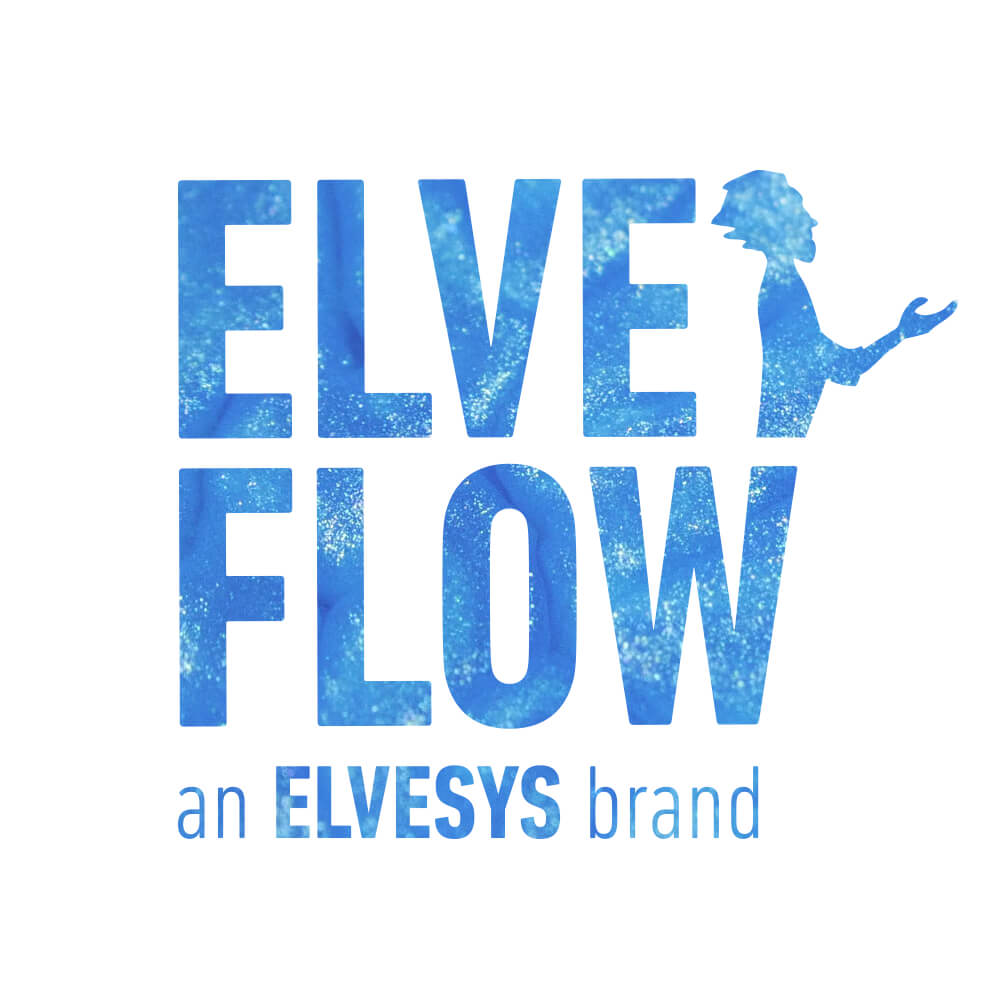
</div>


# Elveflow SDK Tutorial Part 1: Environment Setup

The purpose of this Jupyter Notebook is to work as an introduction to the SDK development with the Elveflow products. The process is shown using a OB1 Pressure Controller with a MFS5D Flow Sensor, but it works also for any other Elvesys product.

At the end of this tutorial, you should be able to connect to an OB1 pressure controller, diagnostic common errors and send basic commands to control the pressure and measure the flow in a setup.

Before starting with this introduction, make sure you have read all the documentation related to your purchased products. Disregarding that information could **risk damaging** the equipment. In case you don't have a copy, you can download all the documents from our [website](https://support.elveflow.com/support/home).

The content of this chapter of the tutorial is the following:
1. Installation
2. Instrument configuration
3. Sensor addition
4. System calibration
5. Main execution routine

## 1.1 Installation
### 1.1.1 Tested system

This tutorial has been written and tested using Windows 10, 64bits, Python 3.8.8, Jupyter Notebook 6.3.0 in October, 2021, with the ESI and SDK version V3.6.0.
The pressure controller is an OB1 MK3+ and the flow sensor a MFS5D.

### 1.1.2 SDK files
The Elveflow Software Development Kit (SDK) latest stable version can be downloaded from the Elveflow [website](https://www.elveflow.com/microfluidic-products/microfluidics-software/elveflow-software-sdk/). The folder contains an installer for the ESI and a zip folder containing the SDK.
The ESI software is required to be installed before using the SDK. Thereafter, unzip it at an easily accessible path like 'C:/dev/SDK' as for now, it is necessary to hardcode some paths on the library to customize it for your own system.

**Note:** If you programming language is a 64 bit version then an additional installer is required.  In your SDK folder, find the path '../SDK/Installx64/Extra Install For x64 Libraries' and run the setup application that you will find inside. 

Then, go into at the path where you unzipped the SDK: '../SDK/Python64' (or Python32 if you are using a 32bit version of Python), open the file 'Elveflow.py' with a text editor and edit the fifth line of the code to match the path of your SDK.

    # This python routine load the ElveflowDLL.
    # It defines all function prototype for use with python lib

    from ctypes import *
    ElveflowDLL=CDLL('C:/dev/SDK/DLL64/DLL64/Elveflow64.dll')# <- change this path

Now, change the paths of the following code cell to match the one of yours and run it. If everything is fine, it should not print any message on the screen.

In [1]:


# tested with Python 3.5.1 and 3.8.8 (IDE Eclipse V4.5.2 + Pydev V5.0.0)
# add python_xx and python_xx/DLL to the project path
# coding: utf8

import sys
from email.header import UTF8

sys.path.append('C:/dev/SDK/DLL64/DLL64')#add the path of the library here
sys.path.append('C:/dev/SDK/Python_64')#add the path of the LoadElveflow.py

from ctypes import *

from array import array
from Elveflow64 import *


## 1.2 Instrument configuration
Once the SDK has been correctly installed, it is also necessary to configure it to work with the desired system. As you previously installed the ESI, an application called NI MAX should have been installed as well. It is needed to check the exact name of the device.

First, connect your device to the power supply, connect its USB cable to the computer you are using and turn it on. Run the ESI at least once to check the connection to your device. After that, go to Windows search bar and type 'NI MAX' without the quotes. It should appear as the first result as you can see in the following figure:

<div>
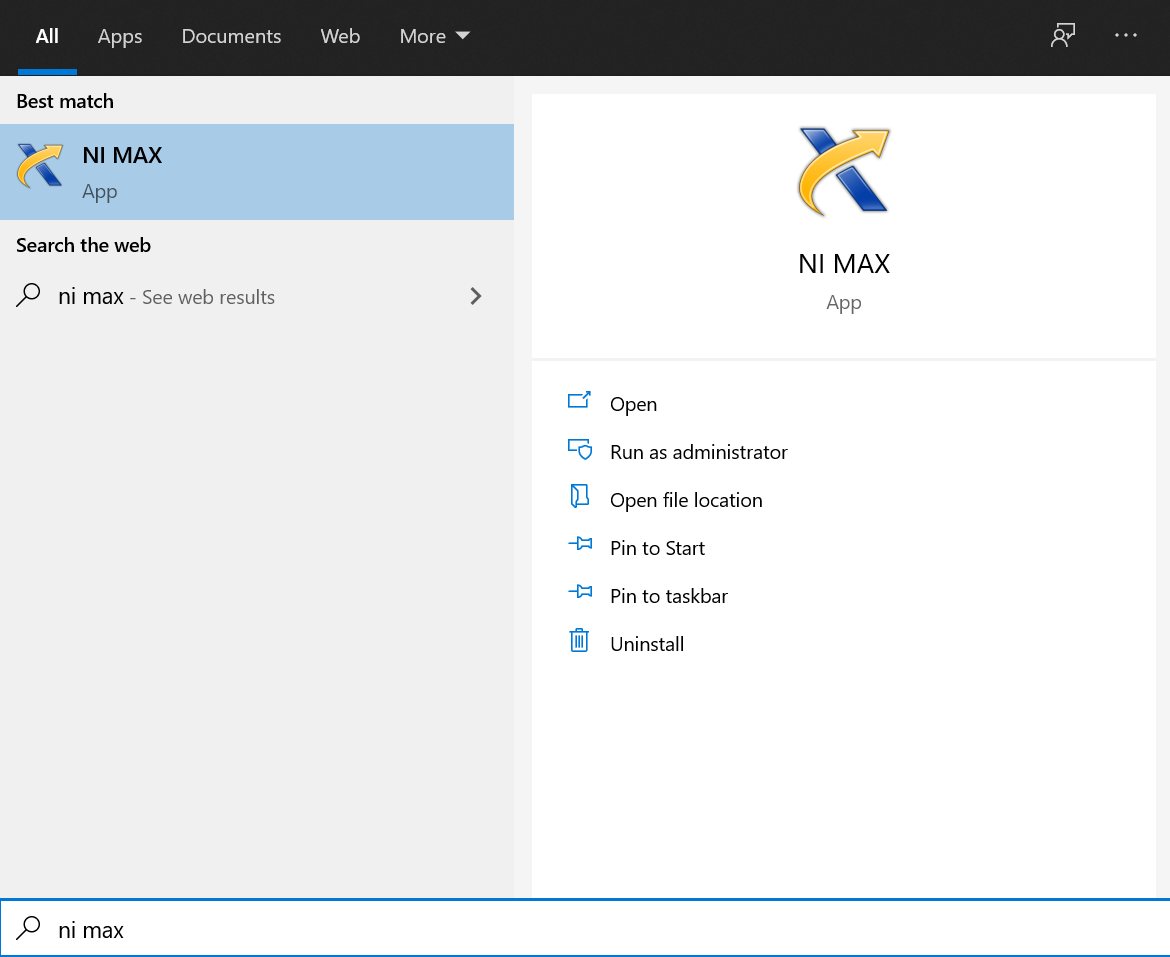
</div>

Then, just unzip the left tabs: 'My System > Devices and Interfaces > ...' like you can see as follows.

<div>
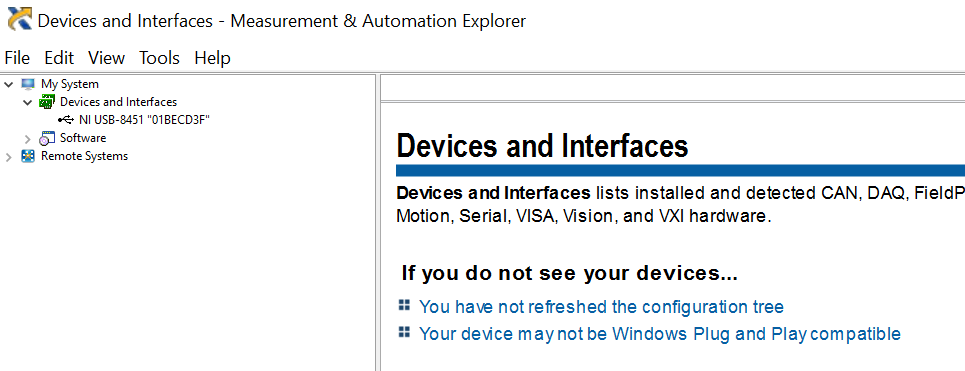
</div>


If you don't have more National Instrument's devices connected to your computer, the only result should be the OB1 Pressure Controller (or the one that you try to configure). Click on it and write down its Serial Number. You will need it for your custom software to interact with the device. In this example, the device Serial Number is 01BECD3F.

The next step is to know the arrangement of pressure regulators that your system has, because our OB1 can be customized to have the right pressure setup for the client. In order to identify them, you can check it on the OB1 User guide, at the installation chapter.

Each regulator value has a different encoding value. The correspondance is the following:

| Regulator type (by range) | Code |
| --- | --- |
| Non-installed | 0 |
| (0, 200) mbar | 1 |
| (0, 2000) mbar | 2 |
| (0, 8000) mbar | 3 |
| (-1000, 1000) mbar | 4 |
| (-1000, 6000) mbar | 5 |

At max, the OB1 controller will have four pressure outputs, thus, in the OB1_Initialization() call of the following code cell, after the serial number, you must specify the regulator type of every channel, setting a zero if a channel is not physically installed. In the following code, only two pressure outputs are installed with regulators of type 3 and 2 respectively.

In [3]:
#
# Initialization of OB1 ( ! ! ! REMEMBER TO USE .encode('ascii') ! ! ! )
#
Instr_ID = c_int32()
print("Instrument name and regulator types are hardcoded in the Python script")

# See User Guide to determine regulator types and NIMAX to determine the instrument name 
error = OB1_Initialization('01BECD3F'.encode('ascii'),3,2,0,0,byref(Instr_ID)) 

# All functions will return error codes to help you to debug your code, for further information refer to User Guide
print('error:%d' % error)
print("OB1 ID: %d" % Instr_ID.value)

Instrument name and regulator types are hardcoded in the Python script
error:0
OB1 ID: 0


If everything went fine, you should have received a simple message as follows:

    Instrument name and regulator types are hardcoded in the Python script
    error:0
    OB1 ID: 0

If it is not the case, one or several of the following issues can be happening:
1. The OB1 is not connected to the power supply or to the computer through the USB wire.
2. The OB1 is not on. The screen should emit blue light.
3. The Serial Number of the device was not correctly written.
4. There are several instances trying to reach the OB1. Close any ESI window running and be sure of using only one Jupyter Notebook instance (of OB1 interfacing code) at time.
5. The computer must be restart after the installation of the extra libraries.
6. The USB wire may need to be unplugged and plugged or changed to another USB port. 

## 1.3 Sensor addition
Once the OB1 has been fully configured, the sensor, or sensors, must be added so they can be read later. To do it, the function: "OB1_Add_Sens()" must be called.

The arguments for the function are:
- The OB1 ID obtained at its initialization.
- Channel to which the sensor is attached.
- Sensor type (see below).
- Digital (1) or Analog (0) communication.
- Calibration: IPA (1) or H20 (0).
- Resolution bits (see below).
- Voltage for custom analog sensors, from 5 to 25V.

To know the sensor type you can use this table which can be also found at the end of the SDK guide:

| Sensor type | Code | Sensor type | Code |
| --- | --- |--- | --- |
| None | 0 | Press 340 mbar | 8 |
| Flow 1-5 muL/min | 1 | Press 1 bar | 9 |
| Flow 7 muL/min | 2 | Press 2 bar | 10 |
| Flow 50 muL/min | 3 | Press 7 bar | 11 |
| Flow 80 muL/min | 4 | Press 16 bar | 12 |
| Flow 1000 muL/min | 5 | Level | 13 |
| Flow 5000 muL/min | 6 | Custom | 14 |
| Press 70 mbar | 7 |   |   |

**Note.** *Level* sensor type stands for all types of level sensor such as bubble detector.

For digital sensors, the calibration adjusts the scale to read correctly the flow depending of the liquid being used. Digital sensors can also have their resolution adjusted:

| Resolution | Code | Resolution | Code |
| --- | --- |--- | --- |
| 9 bits | 0 | 13 bits | 4 |
| 10 bits | 1 | 14 bits | 5 |
| 11 bits | 2 | 15 bits | 6 |
| 12 bits | 3 | 16 bits | 7 |

Higher resolution involves a longer integration time, with up to 75ms for a single measurement at 16bits.

In [4]:
# Add one digital flow sensor with water calibration (OB1 MK3+ only), all information to declare sensors are described in the User Guide
error = OB1_Add_Sens(Instr_ID, 2, 4, 1, 0, 7, 0)
# (CustomSens_Voltage_5_to_25 only works with CustomSensors and OB1 from 2020 and after)
print('error add digit flow sensor:%d' % error)

error add digit flow sensor:0


## 1.4 System calibration
The calibration adjusts the internal pressure measurement of the regulator to increase measurement accuracy. Here you can choose either to use a default calibration table, assuming a perfect behavior of the sensor, either load an existing the file of a previous calibration or make a new one.

If you choose to load a calibration file, you must specify the file location via Calib_path. Otherwise, if you want to run a calibration process, ensure that **ALL** channels are properly closed with adequate caps. You can find more detailed instructions about the calibration procedure at the OB1 User Guide.

**Note**:    
1. The SDK calibration file is not compatible with the ESI calibration file.
2. The calibration usually takes a few minutes to run.

In [5]:
Calib = (c_double*1000)() # Always define array this way, calibration should have 1000 elements

while True:
    answer = input('select calibration type (default, load, new ) : ')
    Calib_path = 'C:\\Users\\Public\\Desktop\\Calibration\\Calib.txt'
    if answer == 'default':
        error = Elveflow_Calibration_Default (byref(Calib),1000)
        break
        
    if answer == 'load':
        error = Elveflow_Calibration_Load (Calib_path.encode('ascii'), byref(Calib), 1000)
        break
        
    if answer == 'new':
        OB1_Calib (Instr_ID.value, Calib, 1000)
        error = Elveflow_Calibration_Save(Calib_path.encode('ascii'), byref(Calib), 1000)
        print('Calib saved in %s' % Calib_path.encode('ascii'))
        break

select calibration type (default, load, new ) : default


## 1.5 Main execution runtine

Once that your system is configured and started, you can run the following main routine with which you will be able to basically control the instrument's pressure output as well as to read the pressure and flow signal if desired.

You can see a summary of the commands of the example at the following table:

| Command | Function | Description |
| --- | --- | --- |
| set_p | OB1_Set_Press()  | Manually set a pressure at a desired channel. |
| get_p | OB1_Get_Press() | Manually get the pressure reading from a desired channnel. |
| get_sens | OB1_Get_Sens_Data() | Manually get the value of any sensor. |
| exit | None | Exit the main loop. |

**Note.** For more information on these functions, please consult the API reference in the SDK User Guide.

In [7]:
while True:
    answer=input('what to do (set_p, get_p, get_sens, or exit) : ')
    if answer=='set_p':
        set_channel=input("select channel(1-4) : ")
        set_channel=int(set_channel) # convert to int
        set_channel=c_int32(set_channel) # convert to c_int32
        set_pressure=input("select pressure (-1000 to 8000 mbars) : ")
        set_pressure=float(set_pressure) 
        set_pressure=c_double(set_pressure) # convert to c_double
        error=OB1_Set_Press(Instr_ID.value, set_channel, set_pressure, byref(Calib),1000) 
        
    if answer=="get_sens":
        data_sens=c_double()
        set_channel=input("select channel(1-4) : ")
        set_channel=int(set_channel) # convert to int
        set_channel=c_int32(set_channel) # convert to c_int32
        error=OB1_Get_Sens_Data(Instr_ID.value,set_channel, 1,byref(data_sens)) # Acquire_data=1 -> read all the analog values
        print('Press or Flow ch', set_channel.value,': ',data_sens.value)
    
    if answer=='get_p':
        set_channel=input("select channel(1-4) : ")
        set_channel=c_int32( int(set_channel) ) # convert to c_int32
        get_pressure=c_double()
        error=OB1_Get_Press(Instr_ID.value, set_channel, 1, byref(Calib),byref(get_pressure), 1000) # Acquire_data=1 -> read all the analog values
        print('error: ', error)
        print('ch',set_channel,': ',get_pressure.value)

    print( 'error :', error)
    
    if answer=='exit':
        break

what to do (set_p, get_p, get_sens, get_all, get_trig, set_trig, add_pid, start, stop, set_target, read_channel, or exit) : exit
error : 0


The output can be something like the following:

    what to do (set_p, get_p, get_sens, or exit) : get_sens
    select channel(1-4) : 2
    Press or Flow ch 2 :  4.724137931034483
    what to do (set_p, get_p, get_sens, or exit) : exit
    error : 0

Here concludes the first part of the tutorial. Go for the second part to know how to perform flow control with our instruments.